# [About Dataset]

The dataset is maintained by the Jet Propulsion Laboratory of California Institute of Technology which is an organization under NASA.

---
## Columns Definition (refer [NASA JPL's glossary](https://cneos.jpl.nasa.gov/glossary/) for further information)

- SPK-ID: Object primary SPK-ID **(remove)**
- Object ID: Object internal database ID **(remove)**
- Object fullname: Object full name/designation **(remove)**
- pdes: Object primary designation **(remove)**
- name: Object IAU name **(remove)**
- NEO: Near-Earth Object (NEO) flag
- PHA: Potentially Hazardous Asteroid (PHA) flag
- H: Absolute magnitude parameter
- Diameter: object diameter (from equivalent sphere) km Unit
- Albedo: Geometric albedo
- Diameter_sigma: 1-sigma uncertainty in object diameter km Unit
- Orbit_id: Orbit solution ID
- Epoch: Epoch of osculation in modified Julian day form
- Equinox: Equinox of reference frame
- e: Eccentricity
- a: Semi-major axis au Unit
- q: perihelion distance au Unit
- i: inclination; angle with respect to x-y ecliptic plane
- tp: Time of perihelion passage TDB Unit
- moid_ld: Earth Minimum Orbit Intersection Distance au Unit

---

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import seaborn as sns

# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
# from sklearn import preprocessing
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

train = pd.read_csv("../input/asteroid-dataset/dataset.csv")

train.isnull().sum()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


id                     0
spkid                  0
full_name              0
pdes                   0
name              936460
prefix            958506
neo                    4
pha                19921
H                   6263
diameter          822315
albedo            823421
diameter_sigma    822443
orbit_id               0
epoch                  0
epoch_mjd              0
epoch_cal              0
equinox                0
e                      0
a                      0
q                      0
i                      0
om                     0
w                      0
ma                     1
ad                     4
n                      0
tp                     0
tp_cal                 0
per                    4
per_y                  1
moid               19921
moid_ld              127
sigma_e            19922
sigma_a            19922
sigma_q            19922
sigma_i            19922
sigma_om           19922
sigma_w            19922
sigma_ma           19922
sigma_ad           19926


# 1. Data Cleaning
---

There are a lot of missing values, let's first remove columns that are just assigned for naming purpose (not useful):
- id
- full_name
- pdes
- orbit_id
- name
- prefix
- equinox
- spkid

Although the columns:
- diameter
- albedo
- diameter_sigma
    
might contain useful insighs, they have a lot of missing values. Therefore, the respective columns should be removed as there is no reliable was to impute the missing values.

---

In [2]:
Xo = train.copy().drop(['id',
                        'full_name', 
                        'pdes',
                        'orbit_id',
                        'name', 
                        'prefix', 
                        'equinox', 
                        'spkid',
                        'diameter',
                        'albedo',
                        'diameter_sigma'], axis='columns', inplace=False)
yo = Xo.pop('pha')
# cat_feature = Xo[['neo','class']].columns
cat_feature = list(Xo.select_dtypes(include = ['object']).columns)
num_feature = list(Xo.select_dtypes(include = ['int64','float64']).columns)
parameters = cat_feature + num_feature + ["pha"]

print("Number of entries: \n" + str(train.shape[0]))
print("\nCategorical Values (Missing): \n" + str(train[cat_feature].isnull().sum()))
print("\nNumerical Values (Missing): \n" + str(train[num_feature].isnull().sum()))

Number of entries: 
958524

Categorical Values (Missing): 
neo      4
class    0
dtype: int64

Numerical Values (Missing): 
H             6263
epoch            0
epoch_mjd        0
epoch_cal        0
e                0
a                0
q                0
i                0
om               0
w                0
ma               1
ad               4
n                0
tp               0
tp_cal           0
per              4
per_y            1
moid         19921
moid_ld        127
sigma_e      19922
sigma_a      19922
sigma_q      19922
sigma_i      19922
sigma_om     19922
sigma_w      19922
sigma_ma     19922
sigma_ad     19926
sigma_n      19922
sigma_tp     19922
sigma_per    19926
rms              2
dtype: int64


---
Removing rows that are not imputable:
- pha
- H
- sigma_ad
- ma

---

In [3]:
X = train[train['pha'].notna()]
X = X[X['H'].notna()]
X = X[X['sigma_ad'].notna()]
X = X[X['ma'].notna()]
X = X[parameters]
X = X.reset_index()
X = X.drop(["index"] ,axis='columns', inplace=False)

# 2. Data Processing
---
- Processing categorical variables.

- [Scale](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02) numerical features

- One-hot encoding on categorical features.
---

In [4]:
# convert to categorical
X['neo'] = X['neo'].astype('category')
X['pha'] = X['pha'].astype('category')
X['class'] = X['class'].astype('category')

# minmax scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X[num_feature])
X_scale = pd.DataFrame(X_scale, columns = num_feature)
X = pd.concat([X_scale,X[cat_feature],X['pha']],axis = 1)

# one-hot encoding
X = pd.get_dummies(X, columns = ['class'])
X = pd.get_dummies(X, columns = ['neo', 'pha'], drop_first = True)
df = X.copy() # keep a copy of precessed dataset

# 3. EDA
---

<AxesSubplot:>

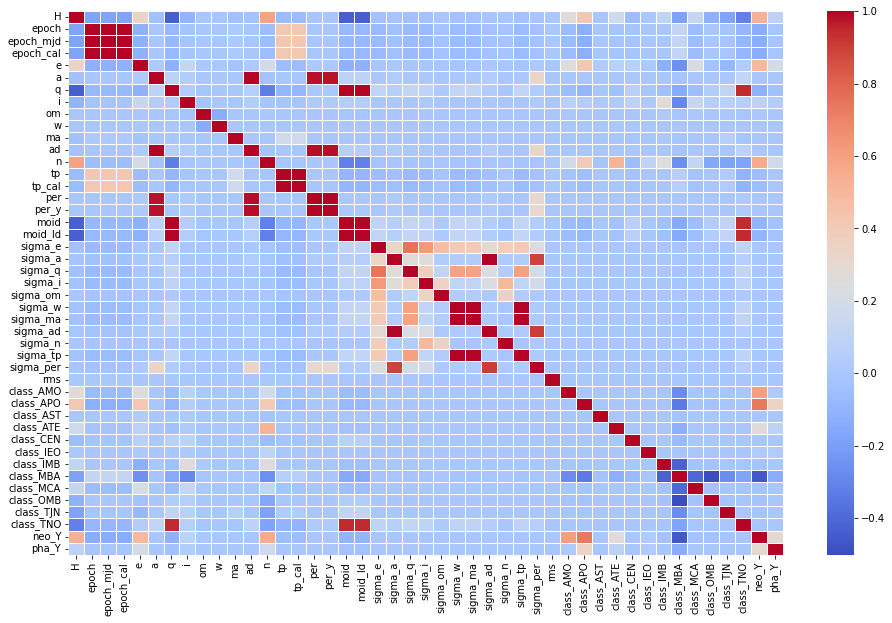

In [5]:
# visualizing the Pearson's Coefficients between features or target
plt.pyplot.figure(figsize=(16,10))
sns.heatmap(X.corr(), annot = False, cmap = "coolwarm", linewidths = 0.5)

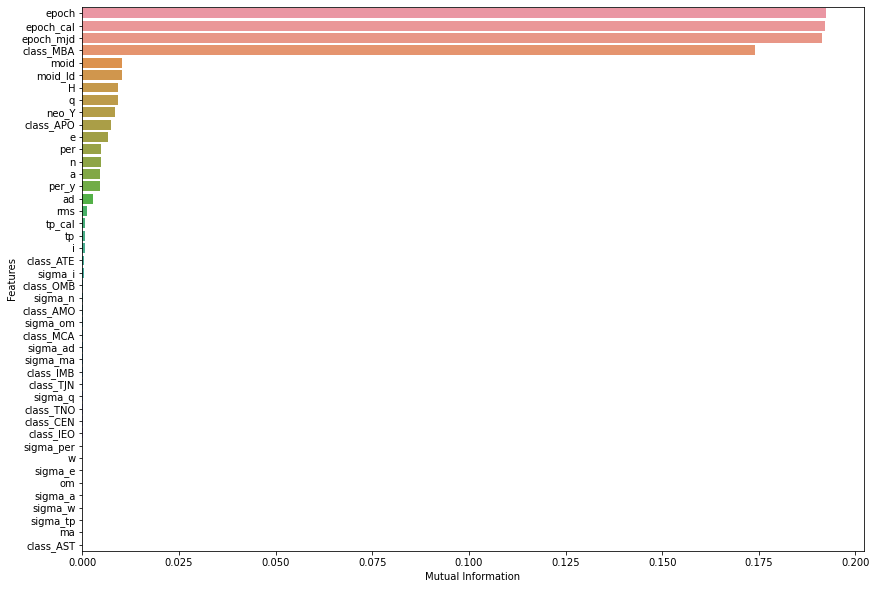

In [6]:
# check on the mutual information between features
from sklearn.feature_selection import mutual_info_classif
features = X.columns.drop('pha_Y')
x = X.copy()
y = x.pop("pha_Y")
feature_series = pd.Series(features, name = "Features")
discrete_features = x.dtypes == int

def mi(x,y,discrete_features):
    mi_score = mutual_info_classif(x,y,discrete_features=discrete_features)
    mi_score = pd.Series(mi_score, name = "Mutual Information")
    mi_df = pd.concat([feature_series, mi_score], axis = 1)
    mi_df = mi_df.sort_values(ascending = False, by = ['Mutual Information'])
    return mi_df

mi_df = mi(x,y,discrete_features)

# visualize mutual information
plt.pyplot.figure(figsize=(14,10))
bp_ax = sns.barplot(y=mi_df['Features'],x=mi_df['Mutual Information'])

In [7]:
# extracting the features with MI more than 0.08 [0.04 if want to inspect more]
mi_large = mi_df[mi_df["Mutual Information"] > 0.001]
large_parameter = mi_large.Features.values
len(large_parameter)

17

---
Parameters with large MI values: 
- 'epoch_cal',
- 'epoch',
- 'epoch_mjd',
- 'class_MBA',
- 'moid',
- 'moid_ld',
- 'H',
- 'q',
- 'neo_Y',
- 'class_APO',
- 'e',
- 'n',
- 'a',
- 'per_y',
- 'per',
- 'ad',
- 'rms'

---
# 4. Model Selection and Development

---
Since the distribution of Hazardous asteroids is way lower than its counterpart, the dataset is heavily imbalanced. To deal with this BalancedBaggingClassifier is adopted.

In [8]:
# check on the distribution of target class
X['pha_Y'].value_counts(normalize = True)*100

0    99.778406
1     0.221594
Name: pha_Y, dtype: float64

Since there is no test data, train-test split is required to obtain validation data.

While we are at it, the model performance metrics calculation function is created to obtain the following metrics:
- precision
- recall
- acuracy
- F1 score

In [9]:
# train-test split
from sklearn.model_selection import train_test_split
y = X.pop('pha_Y')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 0)

result = pd.DataFrame(columns = ['Model', 'Precision', 'Recall', 'Accuracy', 'F1'])

# define a function to calculate metrics
from sklearn import metrics

def calc_metrics(y_valid, preds, model):
    precision = metrics.precision_score(y_valid, preds)
    recall = metrics.recall_score(y_valid, preds)
    accuracy = metrics.accuracy_score(y_valid, preds)
    f1 = metrics.f1_score(y_valid, preds)
    global result
    result = result.append(pd.DataFrame({'Model' : model,
                                         'Precision': precision,
                                         'Recall' : recall,
                                         'Accuracy': accuracy,
                                         'F1' : f1}, index = [0]), 
                           ignore_index = True)
    return result

## Trial :
1. Logistic Regression
2. XGBoost
3. Random Forest

In [10]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


models = [LogisticRegression(random_state = 0), 
          XGBClassifier(random_state = 0, verbosity = 0),
          DecisionTreeClassifier(random_state = 0)]

for model in models:
    classifier = BalancedBaggingClassifier(base_estimator = model,
                                          sampling_strategy = "all",
                                          replacement = False,
                                          random_state = 0)
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_valid)
    calc_metrics(y_valid, preds, model)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

In [11]:
# show the tabulated result
result.sort_values(by = "F1", ascending = False)

,Model,Precision,Recall,Accuracy,F1
2,DecisionTreeClassifier(random_state=0),0.788104,1.0,0.999389,0.881497
1,"XGBClassifier(base_score=None, booster=None, c...",0.785185,1.0,0.999378,0.879668
0,LogisticRegression(random_state=0),0.092657,1.0,0.977733,0.169600
